## Technical Requirements


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings

In [2]:
# --- Configuration ---
plt.rcParams["figure.figsize"] = [14, 7]
warnings.filterwarnings('ignore')

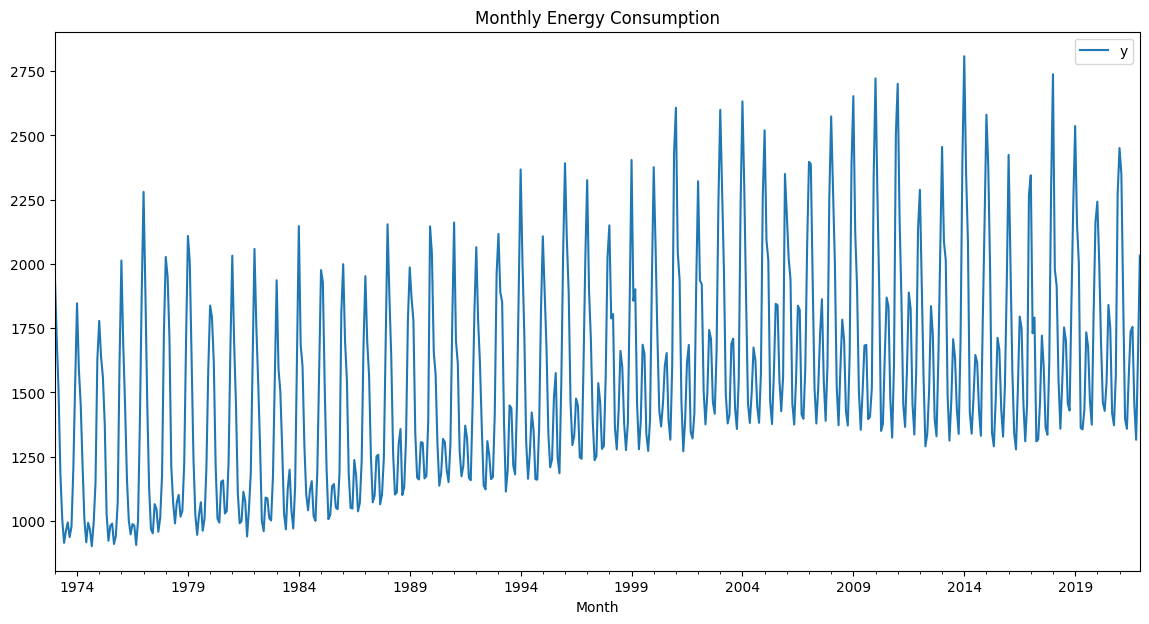

In [3]:
path = Path('../../datasets/Ch13/')
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)

energy.columns = ['y'] # rename column for clarity
energy.index.freq = 'MS' #set frequency
energy.plot(title='Monthly Energy Consumption')
plt.show()

In [4]:
print("Original Data Info:")
energy.info()
print(f"\nOriginal Data Head:\n{energy.head()}")

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 588 entries, 1973-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       588 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB

Original Data Head:
                   y
Month               
1973-01-01  1957.641
1973-02-01  1712.143
1973-03-01  1510.079
1973-04-01  1183.421
1973-05-01  1006.326


In [5]:
energy.head(10)

,y
Month,
1973-01-01,1957.641
1973-02-01,1712.143
1973-03-01,1510.079
1973-04-01,1183.421
1973-05-01,1006.326
1973-06-01,914.949
1973-07-01,961.872
1973-08-01,994.259
1973-09-01,937.083


## Forecasting with LSTM

In [6]:
# --- Preprocessing Functions ---

def fill_missing_forward(df):
    """
    Checks for missing data and fills using forward fill.

    Args:
        df (pd.DataFrame): DataFrame with a time series in a column named 'y'

    Returns:
        pd.DataFrame: DataFrame with missing values filled.
    """
    n_missing = int(df['y'].isna().sum()) # Assuming single column 'y'
    if n_missing > 0:
        print(f'Found {n_missing} missing observations... filling forward.')
        df = df.ffill()
    return df

In [7]:
en_df = fill_missing_forward(energy)

## Short-term foreacst 
### Keras LSTM

In [8]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import (EarlyStopping, 
                                        ReduceLROnPlateau, 
                                        TensorBoard,
                                        ModelCheckpoint)
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

In [9]:
# This is added for Reproducibility
import random 
import tensorflow as tf

SEED = 42 
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [10]:
def create_sequences(df, window_size, target_col='y'):
    """
    Convert a time series into a supervised learning dataset with lagged features.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Time series data with single target column
    window_size : int
        Number of lagged observations to use as input features
    target_col : str, optional
        Name of the column in 'df' that contains the target time series values.
        Default is 'y'
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with lagged features (x1, x2, ...) and target (y)
    """
    try:
        # Extract the target column as a 1D NumPy array
        data_values = df[target_col].values 
    except KeyError:
        raise KeyError(f"""Column '{target_col}' not found in DataFrame. 
                        Please ensure the target column is correctly named.""")

    X_list = [data_values[i:i+window_size] for i in range(len(data_values)-window_size)]
    X = np.array(X_list) # Creates a 2D array (num_sequences, window_size)
    
    # Target is the value immediately following each window
    y_values = data_values[window_size:]
    idx = df.index[window_size:]

    feature_cols = [f'x{i+1}' for i in range(window_size)]

    seq_df = pd.DataFrame(X, columns=feature_cols, index=idx)
    # Assign the target values to a column named 'y' in the new DataFrame
    seq_df['y'] = y_values

    return seq_df

In [11]:
en_seq = create_sequences(en_df, 12)
en_seq.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y
Month,,,,,,,,,,,,,
1974-01-01,1957.641,1712.143,1510.079,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930
1974-02-01,1712.143,1510.079,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448
1974-03-01,1510.079,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448,1451.073
1974-04-01,1183.421,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448,1451.073,1215.228
1974-05-01,1006.326,914.949,961.872,994.259,937.083,978.162,1202.105,1538.568,1846.930,1589.448,1451.073,1215.228,1003.821


In [12]:
en_seq.shape

(576, 13)

In [13]:
class TimeSeriesStandardScaler:
    """
    Standardizes time series data and provides train/val/test splits.
    """
    def __init__(self, df, test_size, val_size):
        """
        Initializes the preprocessor.

        Args:
            df (pd.DataFrame): The DataFrame containing sequences (features and target).
            test_size (int): Number of periods for the test set.
            val_size (int): Number of periods for the validation set.
        """
        self.data = df
        self.test_periods = test_size
        self.val_periods = val_size
        self.mu = None
        self.sigma = None
    
    def split_data(self):
        """
        Splits the data into training, validation, and test sets based on time order.
        """
        n_total = len(self.data)
        
        test_start = n_total - self.test_periods
        val_start = test_start - self.val_periods
        # Create splits maintaining temporal order
        train = self.data.iloc[:val_start]
        val = self.data.iloc[val_start:test_start]
        test = self.data.iloc[test_start:]
             
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, val, test
    
    def _transform(self, data):
        if self.mu is None or self.sigma is None:
            raise ValueError("Scaler not fitted yet. Call fit_transform() first.")
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        """
        Fits the scaler on the training data and transforms train, val, and test sets.
        Scales all features and target using the same parameters derived from the training data.
        """
        train, val, test = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_scaled = self._transform(train)
        test_scaled = self._transform(test)
        val_scaled = self._transform(val)
        return train_scaled, val_scaled, test_scaled
    
    def inverse_transform(self, data):
        """
        Reverses the standardization transformation.
	     Assumes target is the last column in the original DataFrame.
        """
        return (data * self.sigma)+self.mu
        
    def inverse_transform_target(self, data):
        """
        Reverses standardization for target variable only.
        """
        return (data * self.sigma[-1])+self.mu[-1]


In [ ]:
scaler = TimeSeriesStandardScaler(en_seq, test_periods=12, val_multiplier=3)
k_train_scaled, k_val_scaled, k_test_scaled = scaler.fit_transform()


In [ ]:
print(f'''
original: {energy.shape}
train_scaled: {k_train_scaled.shape}
test_scaled: {k_test_scaled.shape}
val_scaled: {k_val_scaled.shape}
''')

In [ ]:
def prepare_keras_input(*args):
    """
    Convert dataframes to numpy arrays formatted for Keras/TensorFlow LSTM models.
    
    Parameters:
    -----------
    *args : list of pandas.DataFrame
        DataFrames containing features and target column 'y'
        
    Returns:
    --------
    tuple
        Tuple containing target arrays followed by feature arrays for each input DataFrame
    """
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1) for col in args]
    
    return *y, *x

In [ ]:
 # For Keras/TensorFlow
(y_train_k, 
 y_val_k, 
 y_test_k, 
 x_train_k, 
 x_val_k, 
 x_test_k) = prepare_keras_input(k_train_scaled.copy(), 
                                  k_val_scaled.copy(), 
                                  k_test_scaled.copy())
        

```python
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=units))
model.add(Dense(1)) 
```

adding Dropout

```python
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=units))
model.add(Dropout(dropout_rate))
model.add(Dense(1)) 
```

adding another LSTM and Dropout layers

```python
model = Sequential()
model.add(Input(shape=input_shape))
model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(LSTM(units=units//2))  # Second LSTM layer with fewer units
model.add(Dropout(dropout_rate))
model.add(Dense(1))
```

In [ ]:
def create_keras_lstm_model(input_shape, units=32, dropout_rate=0.2):
    """
    Creates a stacked Keras LSTM model for time series forecasting.

    Args:
        input_shape (tuple): Shape of the input data (timesteps, features). Example: (WINDOW_SIZE, 1).
        units (int): Number of units in the first LSTM layer.
                     The second LSTM layer will use units//2
        dropout_rate (float): Dropout rate after each LSTM layer.
    Returns:
        keras.Model: Compiled Keras model.
    """
    model = Sequential()
    # Input shape expected by LSTM: (batch_size, timesteps, features)
    # We provide (timesteps, features) via input_shape
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units//2))  # Second LSTM layer with fewer units
    model.add(Dropout(dropout_rate))
    model.add(Dense(1)) # Output layer for forecasting

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=[RootMeanSquaredError(name='rmse'),
                           MeanAbsoluteError(name='mae')])
    return model


In [ ]:
keras_input_shape = (x_train_k.shape[1], x_train_k.shape[2])

keras_lstm_model = create_keras_lstm_model(input_shape=keras_input_shape,
                                     units=32,
                                     dropout_rate=0.2)
keras_lstm_model.summary()

In [ ]:
def train_keras_model(model, x_train, y_train, x_val, y_val,
                      epochs=500, 
                      patience=15,
                      batch_size=32):
    """
    Trains the Keras model with early stopping.

    Args:
        model (keras.Model): The compiled Keras model.
        x_train, y_train: Training data and targets.
        x_val, y_val: Validation data and targets.
        epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs with no improvement to wait before stopping.
        batch_size (int): Training batch size.

    Returns:
        keras.callbacks.History: Training history object.
    """
    print(f"\nTraining Keras model for max {epochs} epochs (patience={patience}, batch_size={batch_size})...")
    early_stopping = EarlyStopping(monitor="val_loss",
                                   patience=patience,
                                   min_delta=0.001, # Small improvement threshold
                                   restore_best_weights=True, # Restore weights from best epoch
                                   verbose=1) 

    # persisting model best weights
    model_checkpoint = ModelCheckpoint(
        filepath='./logs/best_model.keras',
        monitor="val_loss",
        save_best_only=True,
        mode="min",
        verbose=1,
        save_freq="epoch")

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                                  factor=0.2, 
                                  patience=patience//3, 
                                  min_lr=1e-6,
                                  verbose=1)
    
    tensorboard= TensorBoard(log_dir='./logs', 
                             histogram_freq=1)

    history = model.fit(x_train, y_train,
                        shuffle=False, # Important for time series
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        callbacks=[early_stopping, 
                                   reduce_lr, 
                                   tensorboard,
                                   model_checkpoint],
                        verbose=1) # Set to 1 or 2 for progress, 0 for silent
    print("Keras training complete.")
    return history

In [ ]:
history_lstm_keras = train_keras_model(
    keras_lstm_model,
    x_train_k, y_train_k,
    x_val_k, y_val_k,
    epochs=500,
    patience=15,
    batch_size=32
)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./logs

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_forecast(model, x_test, y_test, test_index, history, preprocessor_instance):
    """
    Plots training loss and actual vs forecasted values for Keras model.

    Args:
        model (keras.Model): Trained Keras model.
        x_test (np.ndarray): Scaled test features.
        y_test (np.ndarray): Scaled test target.
        test_index (pd.Index): Datetime index for the test set.
        history (keras.callbacks.History): Training history object.
        preprocessor_instance (TimeSeriesStandardScaler): 
                The fitted preprocessor object used for inverse scaling.
    """
    fig, ax = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: Training and Validation Loss
    # Training loss plot
    pd.Series(history.history['loss']).plot(
                       style='k--',
                       alpha=0.50, 
                       title='Keras Model Loss per Epoch',
                       ax = ax[0], 
                       label='Training loss')
    
    # Validation loss plot
    pd.Series(history.history['val_loss']).plot(
                      style='k',
                      ax=ax[0],
                      label='Validation loss')
    ax[0].legend()
    ax[0].grid(True, linestyle='--', alpha=0.5)

    
    # Plot 2: Actual vs Predicted Values
    # Get predictions
    predicted = model.predict(x_test)
    # Inverse transform predictions and actual values to original scale
    predicted_original = preprocessor_instance.inverse_transform_target(predicted)
    y_test_original = preprocessor_instance.inverse_transform_target(y_test)

    # Plot actual values
    pd.Series(y_test_original.reshape(-1), 
              index=test_index).plot(
                                style='k--', 
                                alpha=0.5, 
                                ax=ax[1], 
                                title='Keras LSTM Forecast vs Actual (Test Set)',
                                label='Actual')
    pd.Series(predicted_original.reshape(-1), 
              index=test_index).plot(
                                style='k',
                                label='Forecast', 
                                ax=ax[1])
    fig.tight_layout()
    ax[1].legend()
    ax[1].grid(True, linestyle='--', alpha=0.5)
    ax[1].set_xlabel('Month')
    ax[1].set_ylabel('Energy Consumption')
    plt.show()

    mae_keras = mean_absolute_error(y_test_original, predicted_original)
    rmse_keras = np.sqrt(mean_squared_error(y_test_original, predicted_original))
    print(f"Keras Test Set MAE:  {mae_keras:.4f}") 
    print(f"Keras Test Set RMSE: {rmse_keras:.4f}") 

In [ ]:
history_lstm_keras.history.keys()

In [ ]:
plot_forecast(keras_lstm_model, 
              x_test_k, 
              y_test_k, 
              k_test_scaled.index, 
              history_lstm_keras, scaler)

### Darts LSTM

In [ ]:
import darts
darts.__version__

In [ ]:
from darts.models import RNNModel, BlockRNNModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse, mae
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch

In [ ]:
en_cp = en_df.copy().reset_index()

In [ ]:
ts = TimeSeries.from_dataframe(en_cp, 
                               time_col='Month', 
                               value_cols='y', 
                               freq='MS')
ts = ts.astype(np.float32)

In [ ]:
# split_frac = 0.10
# n_total = len(ts)
# n_test = 57
# remaining = n_total - n_test
# n_val = int(remaining * split_frac)
# train = ts[:-(n_test+n_val)]
# val = ts[-(n_test+n_val):-n_test]
# test = ts[-n_test:]

In [ ]:
# new way to split
n_total = len(ts)
n_test = 12 #88 #24
n_val = 36 #88#int(n_test * 1.5)

# Calculate split indices
test_start = n_total - n_test
val_start = test_start - n_val
        
# Create splits maintaining temporal order
d_train = ts[:val_start]
d_val = ts[val_start:test_start]
d_test = ts[test_start:]

In [ ]:
# Ensure test set length is exactly 57 to match our Keras example
# test_length = 57
# val_split_point = len(ts) - test_length  # Reserve last 57 for test
# train, val = ts[:val_split_point], ts[val_split_point:]
print(f'''
train: {len(d_train)}
val : {len(d_val)}
test: {len(d_test)}''')

In [ ]:
from sklearn.preprocessing import StandardScaler
d_scaler = Scaler(StandardScaler())

d_train_scaled = d_scaler.fit_transform(d_train)
d_val_scaled = d_scaler.transform(d_val)
d_test_scaled = d_scaler.transform(d_test)

In [ ]:
# Darts LSTM parameters
darts_lstm_params = {
    'model':'LSTM',            # Specify the RNN type
    'input_chunk_length': 12,  # How many time steps the model sees (your 'window'),
    'training_length': 13,
    'hidden_dim': 32,  # LSTM units
    'n_rnn_layers': 2, # Number of LSTM layers
    'dropout': 0.2,    # Dropout rate
    'batch_size': 32,  # Batch size for training
    'n_epochs': 500,   # Max number of epochs
    'optimizer_kwargs': {'lr': 0.001}, # Adam is default, set learning rate
    'random_state': 42, # For reproducibility
    'force_reset':True  # Ensure fresh model training
}

In [ ]:
# Define PyTorch Lightning callbacks (e.g., Early Stopping)
# The logs_key='val_loss' assumes the validation loss is logged with this key
# Darts models using PyTorch Lightning often log validation loss automatically
PATIENCE=15
early_stopper = EarlyStopping(
    monitor="val_loss",  # Darts/PyTorch Lightning default validation loss metric name
    patience=PATIENCE,         # Early stopping patience
    min_delta=0.001,     # Minimum change to qualify as an improvement
    mode='min',          # We want to minimize loss
    verbose=True)

In [ ]:
trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, # Show training progress bar
    "accelerator":"gpu", "devices": [0], # Use GPU for training
    #"accelerator":"cpu" # Use CPU for training
}

In [ ]:
lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        "verbose": True
    }

In [ ]:
darts_lstm_model = RNNModel(
    **darts_lstm_params,
    model_name='energy_lstm',
    log_tensorboard=True,       # Set True to use TensorBoard
    save_checkpoints=True,      # Set True to save model checkpoints
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs # Pass trainer args including callbacks
)

In [ ]:
# Add this check after model creation
print(f"Darts input chunk length: {darts_lstm_model.input_chunk_length}")
print(f"Darts output chunk length: {darts_lstm_model.output_chunk_length}")
# print(f"Darts output chunk length: {darts_lstm_model.training_length}")

In [ ]:
darts_lstm_model.fit(d_train_scaled,
                     val_series=d_val_scaled,
                     verbose=True) # verbose=True shows epoch progress

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=darts_logs/

In [ ]:
best_darts_model = darts_lstm_model.load_from_checkpoint(
                               model_name="energy_lstm", 
                               best=True)
best_darts_model

In [ ]:
full_series_scaled = d_train_scaled.append(d_val_scaled).append(d_test_scaled)
one_step_forecast_scaled= darts_lstm_model.historical_forecasts(
    series=full_series_scaled,
    start=d_test_scaled.start_time(),
    forecast_horizon=1, # We only want one-step-ahead predictions
    stride=1,           # Move one step at a time
    retrain=False,      # Do not retrain the model at each step
    verbose=True
)

In [ ]:
one_step_forecast = d_scaler.inverse_transform(one_step_forecast_scaled)

In [ ]:
one_step_forecast_scaled.start_time()

In [ ]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
one_step_forecast.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts LSTM Forecast vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
rmse_val = rmse(d_test, one_step_forecast)
mae_val = mae(d_test, one_step_forecast)
print(f"Darts Validation Set MAE:  {mae_val:.4f}")
print(f"Darts Validation Set RMSE: {rmse_val:.4f}")

In [ ]:
d_train_val_scaled = d_train_scaled.append(d_val_scaled)
preds_scaled = best_model.predict(n=len(d_test), 
                                  series=d_train_val_scaled)

In [ ]:
preds_energy_inv = d_scaler.inverse_transform(preds_scaled)

In [ ]:
preds_energy_inv.to_dataframe()

In [ ]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
preds_energy_inv.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts LSTM Forecast vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
rmse_val = rmse(d_test, preds_energy_inv)
mae_val = mae(d_test, preds_energy_inv)
print(f"Darts Validation Set MAE:  {mae_val:.4f}")
print(f"Darts Validation Set RMSE: {rmse_val:.4f}")


### NeuralForecast LSTM

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM as NF_LSTM
from neuralforecast.losses.pytorch import MAE, MSE
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error

logger = TensorBoardLogger("nf_tensorboard_log", name="LSTM")

In [ ]:
nf_df = energy.copy().reset_index()
nf_df.rename(columns={'Month': 'ds'}, inplace=True)
nf_df['unique_id'] = 'energy' # Add a unique_id column for NeuralForecast
print(nf_df.head())

In [ ]:
# Align with previous examples
WINDOW_SIZE = 24 # This is `input_size` in NeuralForecast terms
TEST_LENGTH = 12 # Number of steps to forecast, 'h' in NeuralForecast

train_nf = nf_df.iloc[:-TEST_LENGTH]
test_nf = nf_df.iloc[-TEST_LENGTH:]

In [ ]:
print(train_nf.shape)
print(test_nf.shape)

In [ ]:
# Add checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor="valid_loss",
    mode="min",
    save_top_k=1,
)

# lr_scheduler_kwargs = {
#     "mode": "min",
#     "factor": 0.2,
#     "patience": PATIENCE//3, 
#     "min_lr": 1e-6,
#     "verbose": True,
# }

In [ ]:
# class CustomLSTM(NF_LSTM):
#     def validation_step(self, batch, batch_idx):
#         # Compute predictions and loss as per your model
#         x, y = batch  # adjust as needed
#         y_hat = self(x)
#         loss = F.mse_loss(y_hat, y)
#         # Log val_loss for epoch-level aggregation and callback access
#         self.log("val_loss", loss, on_epoch=True, prog_bar=True)
#         return loss
        
#     def configure_optimizers(self):
#         optimizer=torch.optim.Adam(self.parameters(), lr=0.003)
#         scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(\
#             optimizer=optimizer,
#             mode='min',
#             factor=0.2, 
#             patience=PATIENCE//3,
#             verbose=True
#         )
#         scheduler_config = {
#             'scheduler': scheduler,
#             'interval': 'epoch',
#             'frequency': 1,
#             'monitor': 'val_loss',
#             'strict': True
#         }
#         return {'optimizer': optimizer, 'lr_scheduler': scheduler_config}


In [ ]:
len(train_nf)

In [ ]:
import math

batch_size = 32
steps_per_epoch = math.ceil(len(train_nf) / batch_size)
steps_per_epoch

In [ ]:
# NeuralForecast LSTM parameters
PATIENCE = 15
nf_lstm_params = {
    'h': TEST_LENGTH, # Forecast horizon 
    'input_size': WINDOW_SIZE, 
    'encoder_n_layers': 2, # Number of layers for the LSTM 
    'encoder_hidden_size': 32, # Hidden state units 
    'encoder_dropout': 0.2, # Dropout regularization applied to LSTM outputs 
    'max_steps': steps_per_epoch * 500, # to match 500 epochs like Keras and Darts
    'batch_size': batch_size, 
    'learning_rate': 0.001, 
    'num_lr_decays': PATIENCE//3,
    'early_stop_patience_steps': PATIENCE, # Number of validation iterations before early stopping 
    'val_check_steps': steps_per_epoch, # Number of training steps the model evaluates its performance on val set
    'scaler_type': 'standard', # Type of scaler for normalization 
    'random_seed': 42, # For reproducibility
    'logger': logger, # to use with TensorBoard
  #  'decoder_layers':0, # Set to zero to remove the MLP decoder layer.
    'enable_checkpointing': True,
    'recurrent': False, # True means one-step while False means multistep
    'callbacks': [checkpoint_callback]
}
# Instantiate the NeuralForecast LSTM model
lstm = NF_LSTM(**nf_lstm_params)

In [ ]:
# Define the models to be used in NeuralForecast
models = [lstm]

# Create the NeuralForecast object
# The `freq` parameter time series alignment
nf_lstm_model = NeuralForecast(models=models, freq='MS')

In [ ]:
# Fit the model. NeuralForecast handles data splitting internally for validation
# You can pass the entire `nf_df` and it will use `h` and `val_size` (if specified)
# to handle the splitting for you.

# `val_size` here is the number of steps for validation
#val_size = 88
nf_lstm_model.fit(df=train_nf, val_size= 36) 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=nf_tensorboard_log/

In [ ]:
# Make predictions. The `predict` method uses the `h` defined in the model.
# It forecasts from the end of the `df` used in `fit`.
nf_forecast = nf_lstm_model.predict()
len(nf_forecast)

In [ ]:
nf_forecast.columns

In [ ]:
# Extract the predictions for our 'energy' unique_id and set the index
nf_forecast_df = nf_forecast[nf_forecast['unique_id'] == 'energy'].set_index('ds')
nf_forecast_df = nf_forecast_df[['LSTM']] # Select the 'LSTM' column, which contains the predictions
nf_forecast_df.head()

In [ ]:
test_nf.head()

In [ ]:
# Prepare the actual test data for plotting
test_nf.set_index('ds', inplace=True)

plt.figure(figsize=(16, 5))
test_nf['y'].plot(label='Actual', linestyle='--', alpha=0.65)
nf_forecast_df['LSTM'].plot(label='Forecast', color='k', alpha=0.65)
plt.title('NeuralForecast LSTM Forecast vs Actuals (Test Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Calculate metrics
mae_nf = mean_absolute_error(test_nf['y'], nf_forecast_df['LSTM'])
rmse_nf = np.sqrt(mean_squared_error(test_nf['y'], nf_forecast_df['LSTM']))

print(f"NeuralForecast Test Set MAE:  {mae_nf:.4f}")
print(f"NeuralForecast Test Set RMSE: {rmse_nf:.4f}")

## There is more

### Keras

In [ ]:
# manually loading best weights
keras_lstm_model.load_weights('./logs/best_model.keras')


### Darts

In [ ]:
pred_scaled_lm = darts_lstm_model.predict(n=len(d_test), series=d_train_val_scaled)
pred_inv_lm = d_scaler.inverse_transform(pred_scaled_lm)

rmse_val = rmse(d_test, pred_inv_lm)
mae_val = mae(d_test, pred_inv_lm)
print(f"Darts Validation Set MAE:  {mae_val:.4f}")
print(f"Darts Validation Set RMSE: {rmse_val:.4f}")


In [ ]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
pred_inv_lm.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts LSTM Forecast vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Multioutput

In [ ]:
# Darts LSTM parameters
darts_blocklstm_params = {
    'model':'LSTM',            # Specify the RNN type
    'input_chunk_length': 24,  # How many time steps the model sees (your 'window')
    'output_chunk_length': 12,  # How many steps the model predicts forward at a time
    'hidden_dim': 32,  # LSTM units
    'n_rnn_layers': 2, # Number of LSTM layers
    'dropout': 0.2,    # Dropout rate
    'batch_size': 32,  # Batch size for training
    'n_epochs': 500,   # Max number of epochs
    'optimizer_kwargs': {'lr': 0.003}, # Adam is default, set learning rate
    'random_state': 42, # For reproducibility
    'force_reset':True  # Ensure fresh model training
}

In [ ]:
PATIENCE=15
early_stopper = EarlyStopping(
    monitor="val_loss",  # Darts/PyTorch Lightning default validation loss metric name
    patience=PATIENCE,         # Early stopping patience
    min_delta=0.001,     # Minimum change to qualify as an improvement
    mode='min',          # We want to minimize loss
    verbose=True)

In [ ]:
trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True, # Show training progress bar
    "accelerator":"gpu", "devices": [0], # Use GPU for training
    #"accelerator":"cpu" # Use CPU for training
}

In [ ]:
lr_scheduler_kwargs = {
        "mode": "min",
        "monitor": "val_loss",
        "factor": 0.2,
        "patience": PATIENCE//3, 
        "min_lr": 1e-6,
        "verbose": True
    }

In [ ]:
darts_blocklstm_model = BlockRNNModel(
    **darts_blocklstm_params,
    model_name='energy_blocklstm',
    # log_tensorboard=True,       # Set True to use TensorBoard
    save_checkpoints=True,      # Set True to save model checkpoints
    lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs= lr_scheduler_kwargs,
    pl_trainer_kwargs=trainer_kwargs # Pass trainer args including callbacks
)

In [ ]:
d_val_scaled.shape

In [ ]:
darts_blocklstm_model.fit(d_train_scaled,
                     val_series=d_val_scaled,
                     verbose=True) # verbose=True shows epoch progress

In [ ]:
best_block_model = darts_blocklstm_model.load_from_checkpoint(
                               model_name="energy_blocklstm", 
                               best=True)

In [ ]:
d_train_val_scaled = d_train_scaled.append(d_val_scaled)
block_preds_scaled = best_block_model.predict(n=len(d_test), 
                                  series=d_train_val_scaled)
block_preds_energy = d_scaler.inverse_transform(block_preds_scaled)


In [ ]:
rmse_val = rmse(d_test, block_preds_energy)
mae_val = mae(d_test, block_preds_energy)
print(f"Darts Validation Set MAE:  {mae_val:.4f}")
print(f"Darts Validation Set RMSE: {rmse_val:.4f}")

In [ ]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='--', alpha=0.65) # Plot full historical data
block_preds_energy.plot(label='Forecast', color='k', alpha=0.65)
plt.title('Darts Block LSTM Forecast vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
plt.figure(figsize=(16, 5))
d_test.plot(label='Actual', linestyle='-', alpha=0.30) # Plot full historical data
block_preds_energy.plot(label='BlockForecast',  linestyle='-.', color='r', alpha=0.65)
preds_energy_inv.plot(label='Forecast', linestyle='--', color='g', alpha=0.65)
plt.title('Darts Block LSTM Forecast vs Actuals (Validation Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### NeuralForecast

In [ ]:
# Rebuild parameters with early stopping disabled
reload_params = nf_lstm_params.copy()
reload_params.update({
    'max_steps': 0,                  # Prevent training
    'early_stop_patience_steps': -1, # Disable NeuralForecast's auto EarlyStopping
})
reload_params.pop('callbacks', None) # Remove any callback references

In [ ]:
reload_params

In [ ]:
file_path = 'nf_tensorboard_log/LSTM/version_2/checkpoints/epoch=269-step=270.ckpt'
nf_best_model = NF_LSTM.load_from_checkpoint(file_path, **reload_params )

In [ ]:
nf_best_model.hparams

In [ ]:
# nf_best_model.eval()

In [ ]:
nf_loaded = NeuralForecast(models=[nf_best_model], freq='MS')

In [ ]:
nf_loaded.fit(df=train_nf, val_size=0)

In [ ]:
nf_best_preds = nf_loaded.predict()
# Extract the predictions for our 'energy' unique_id and set the index
nf_forecast_bm = nf_best_preds[nf_best_preds['unique_id'] == 'energy'].set_index('ds')
nf_forecast_bm = nf_forecast_bm[['LSTM']]

In [ ]:
# Calculate metrics
mae_nf = mean_absolute_error(test_nf['y'], nf_forecast_bm['LSTM'])
rmse_nf = np.sqrt(mean_squared_error(test_nf['y'], nf_forecast_bm['LSTM']))

print(f"NeuralForecast Test Set MAE:  {mae_nf:.4f}")
print(f"NeuralForecast Test Set RMSE: {rmse_nf:.4f}")

In [ ]:
plt.figure(figsize=(16, 5))
test_nf['y'].plot(label='Actual', linestyle='--', alpha=0.65)
nf_forecast_bm['LSTM'].plot(label='Forecast', color='k', alpha=0.65)
plt.title('NeuralForecast LSTM Forecast vs Actuals (Test Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Multivariate Time Series

In [17]:
import pandas as pd
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape
from darts.models import BlockRNNModel
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import ElectricityConsumptionZurichDataset
import numpy as np

In [18]:
zurich_en = ElectricityConsumptionZurichDataset().load()

In [19]:
zurich_en_df = zurich_en.to_dataframe()

In [20]:
zurich_en_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 268705 entries, 2015-01-01 00:00:00 to 2022-08-31 00:00:00
Freq: 15min
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Value_NE5      268705 non-null  float64
 1   Value_NE7      268705 non-null  float64
 2   Hr [%Hr]       268705 non-null  float64
 3   RainDur [min]  268705 non-null  float64
 4   StrGlo [W/m2]  268705 non-null  float64
 5   T [°C]         268705 non-null  float64
 6   WD [°]         268705 non-null  float64
 7   WVs [m/s]      268705 non-null  float64
 8   WVv [m/s]      268705 non-null  float64
 9   p [hPa]        268705 non-null  float64
dtypes: float64(10)
memory usage: 22.6 MB


In [21]:
zurich_en_df.index.freq

<15 * Minutes>

In [22]:
zurich_en = zurich_en.resample(freq="D", method='mean')

In [23]:
zurich_en.columns

Index(['Value_NE5', 'Value_NE7', 'Hr [%Hr]', 'RainDur [min]', 'StrGlo [W/m2]',
       'T [°C]', 'WD [°]', 'WVs [m/s]', 'WVv [m/s]', 'p [hPa]'],
      dtype='object', name='component')

In [24]:
zurich_en = zurich_en.astype(np.float32)

In [25]:
# extract temperature, solar irradiation and rain duration
zurich_weather = zurich_en[["T [°C]", "StrGlo [W/m2]", "RainDur [min]"]]

In [26]:
zurich_en = zurich_en["Value_NE5"]

In [27]:
zurich_en.freq

<Day>

<Axes: xlabel='Timestamp'>

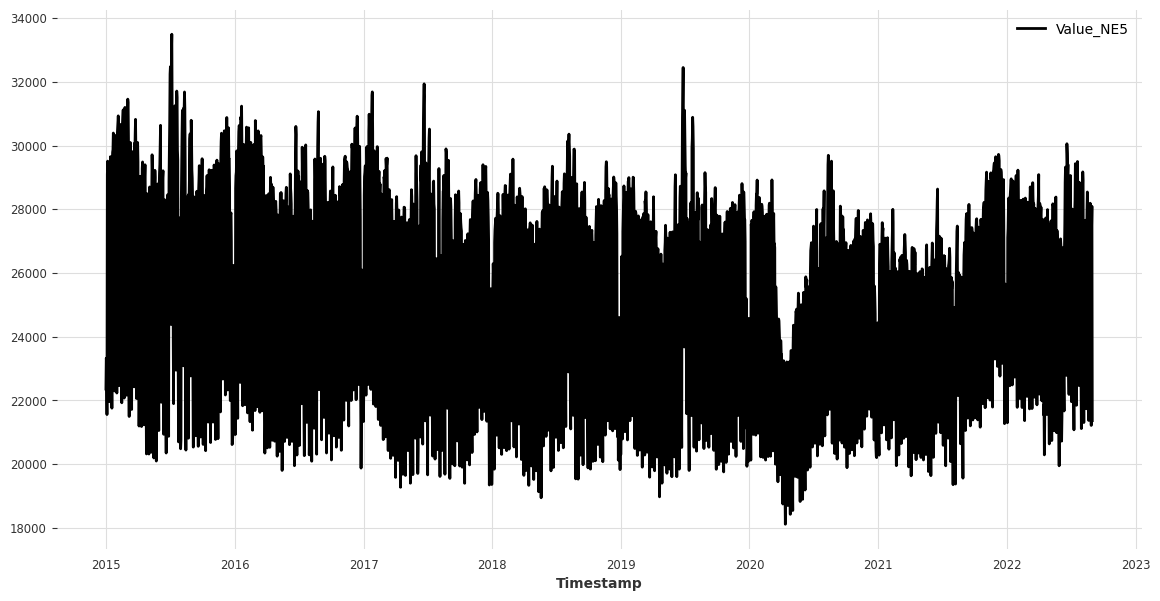

In [28]:
zurich_en.plot()

<Axes: xlabel='Timestamp'>

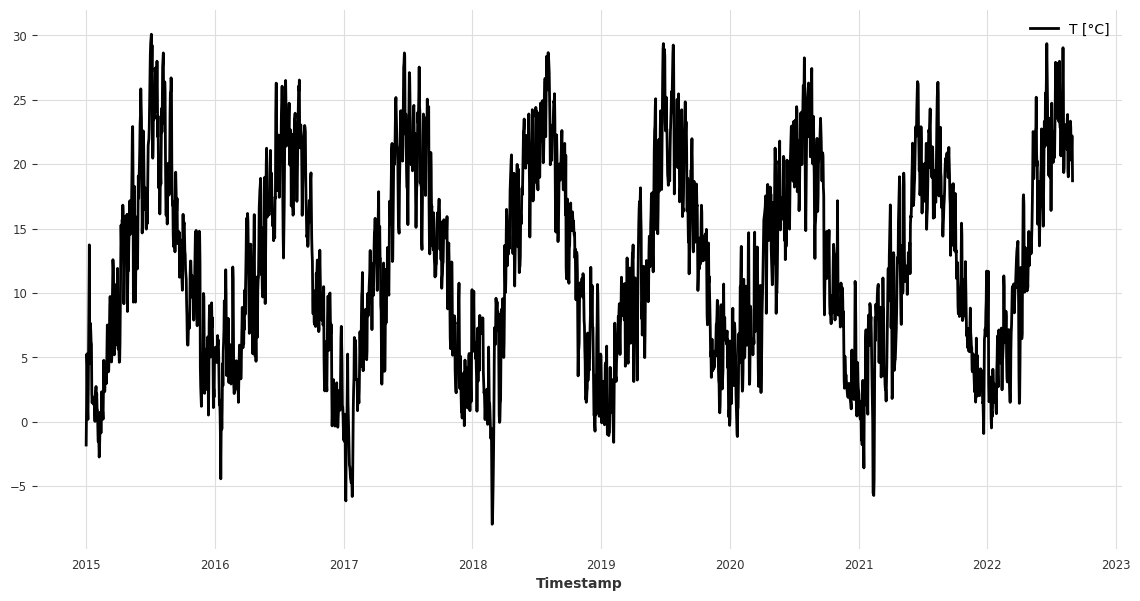

In [29]:
zurich_weather['T [°C]'].plot()

In [30]:
zurich_weather.freq

<Day>

In [31]:
cutoff = pd.Timestamp("2019-12-31")
zurich_en_train, zurich_en_val = zurich_en.split_after(cutoff)

In [32]:
zurich_en_train.shape

(1826, 1, 1)

In [33]:
cutoff = pd.Timestamp("2020-03-31")
zurich_en_val, zurich_en_test = zurich_en_val.split_after(cutoff)

In [34]:
zurich_en_val.shape

(91, 1, 1)

In [35]:
zurich_en_test.shape

(883, 1, 1)

<Axes: xlabel='Timestamp'>

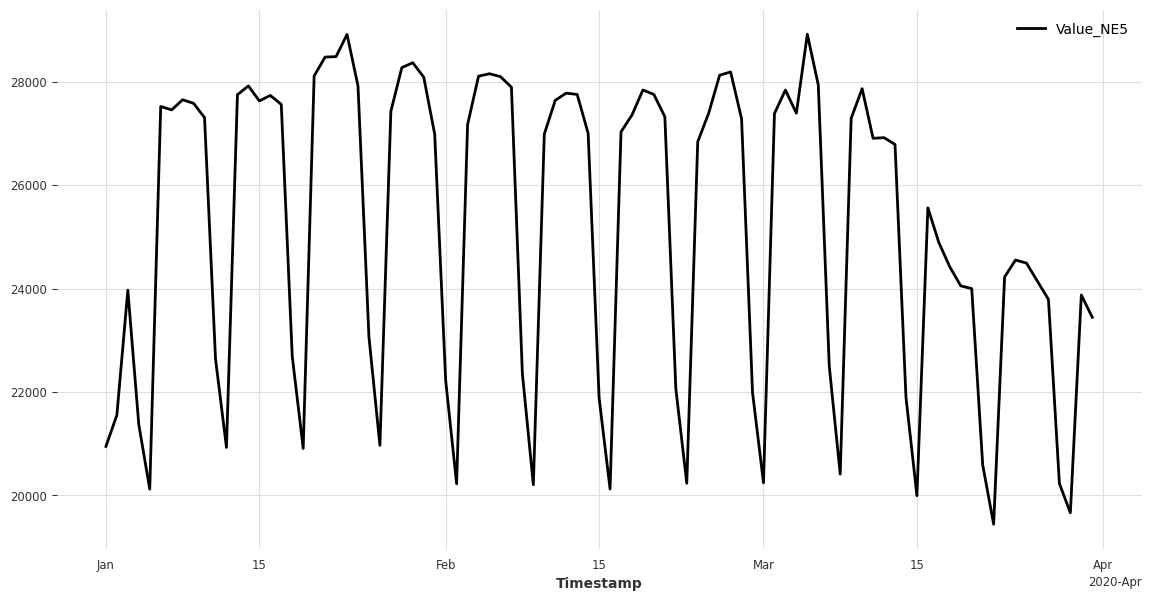

In [36]:
zurich_en_val.plot()

<Axes: xlabel='Timestamp'>

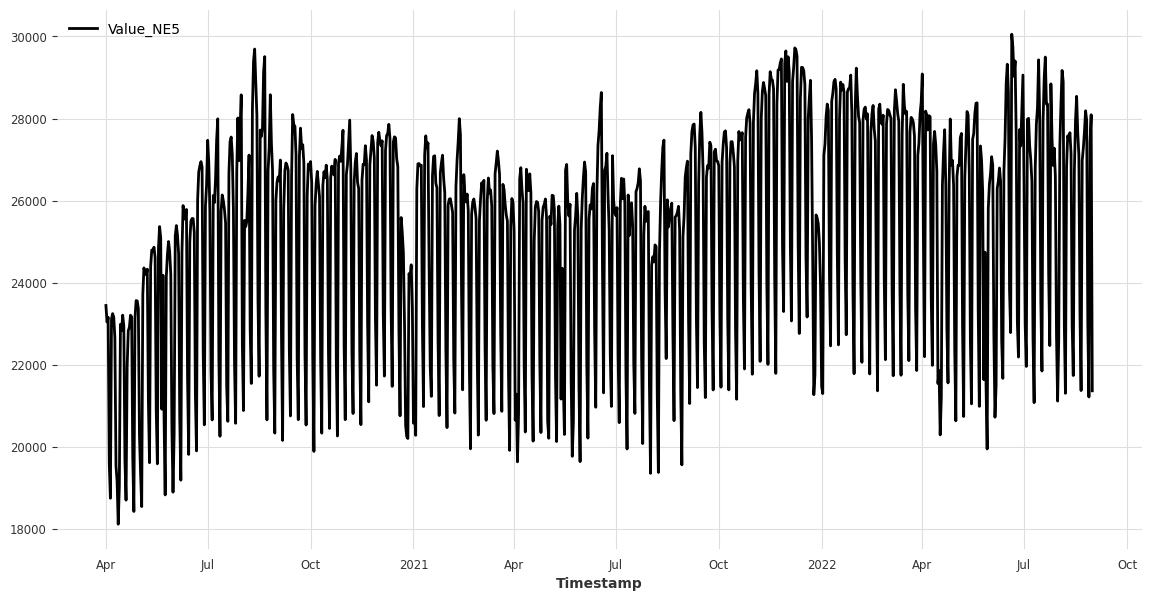

In [37]:
zurich_en_test.plot()

In [ ]:
scaler_y = Scaler()


train_sc= scaler_y.fit_transform(zurich_en_train)
val_sc = scaler_y.transform(zurich_en_val)
test_sc = scaler_y.transform(zurich_en_test)
series_sc = scaler_y.transform(zurich_en)

In [ ]:
cutoff = pd.Timestamp("2019-12-31")
zurich_weather_train, zurich_weather_val = zurich_weather.split_after(cutoff)
cutoff = pd.Timestamp("2020-03-31")
zurich_weather_val, zurich_weather_test = zurich_weather_val.split_after(cutoff)

scaler_cov = Scaler()
cov_train_sc= scaler_cov.fit_transform(zurich_weather_train)
cov_val_sc = scaler_cov.transform(zurich_weather_val)
cov_test_sc = scaler_cov.transform(zurich_weather_test)
cov_sc = scaler_cov.transform(zurich_weather)

In [ ]:
model = RNNModel(model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Zur_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True)           

# # Fit the model with transformed target data and covariates
model.fit(
    series=train_sc,
    future_covariates=cov_train_sc,
    val_series=val_sc,
    val_future_covariates=cov_val_sc, 
    # verbose=True
)

In [ ]:
train_val_sc = train_sc.append(val_sc)

In [ ]:
forecast = model.predict(
    n=len(test_sc),
    series=train_val_sc,                 # context series
    future_covariates=cov_sc
)

In [ ]:
forecast = scaler_y.inverse_transform(forecast)
forecast.plot()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
zurich_en_test.plot(label='Actual', linestyle='-', alpha=0.65)
forecast.plot(label='Forecast', color='k', linestyle='--', alpha=0.35)
plt.title('NeuralForecast LSTM Forecast vs Actuals (Test Set)')
plt.xlabel('Month')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()